## Dataset generation from deformable mirror

A Parabolic GRIN fiber or a Step-Index fiber can be used

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from mmfsim.grid import Grid
from mmfsim.fiber import GrinFiber, StepIndexFiber
from mmfsim.datasets import SimulatedGrinSpeckleOutputDataset, SimulatedStepIndexSpeckleOutputDataset, SimulatedSpeckleOutputDataset

### Setup

Set the computation grid and the fiber characteristics

In [8]:
fiber_type: str = 'step' # 'grin' or 'step'
grid_settings: dict = {'pixel_size': 1e-6, 'pixel_numbers': (64, 64)}
fiber_settings: dict = {'radius': 25e-6, 'wavelength': 1064e-9, 'n1': 1.465, 'n2': 1.44839}
dataset_settings: dict = {'length': 5000, 'degen': True, 'phases_dim': (8,8)}
fourier_settings: dict = {'pad': 1}
export_settings: dict = {'return_output_fields': True, 'add_exp_noise': True, 'noise_func': np.max, 'file_type': 'hdf5'}

### Dataset generation

Generate the grid and the fiber

In [9]:
grid = Grid(**grid_settings)

if fiber_type.lower() in ['grin']:
    fiber = GrinFiber(**fiber_settings)
elif fiber_type.lower() in ['step', 'si']:
    fiber = StepIndexFiber(**fiber_settings)
else:
    raise ValueError(f"Unknown fiber type.")
print(fiber)

StepIndexFiber instance with:
  - Radius: 25.0 um
  - Core index: 1.465
  - Cladding index: 1.44839
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.220
  - Number of guided LP modes: 140
  - Number of guided LP modes (counting degenerates): 269
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[ 1.46491477  0.          0.          1.        ]
 [ 1.46478363  2.          1.          1.        ]
 [ 1.46461132  4.          2.          1.        ]
 [ 1.46455097  1.          0.          2.        ]
 [ 1.46440012  6.          3.          1.        ]
 [ 1.46427477  3.          1.          2.        ]
 [ 1.46415143  8.          4.          1.        ]
 [ 1.46395609  5.          2.          2.        ]
 [ 1.46389667  2.          0.          3.        ]
 [ 1.46386618 10.          5.          1.        ]]


Compute and store the modes for a much faster dataset generation, plot one for checking extent

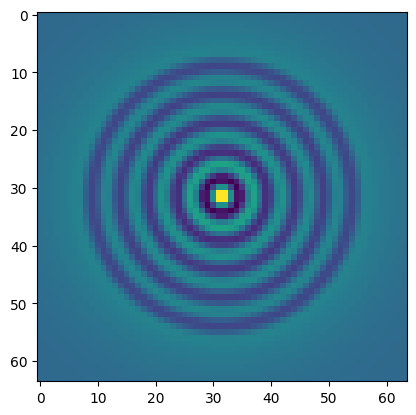

In [10]:
fiber.compute_modes_fields(grid)
plt.imshow(fiber._modes[:,:,1,-1])

Compute dataset

In [53]:
dset = SimulatedStepIndexSpeckleOutputDataset(fiber, grid, N_modes=fiber._N_modes_degen, length=dataset_settings['length'])
dset.compute_from_transfer_matrix(phases_dim=dataset_settings['phases_dim'])
dset.compute_fourier_transforms(**fourier_settings)

Found 12 input variable weights below threshold 0.001 to delete.
Successfully deleted low weight input variables.
Computed TM row 1/52
Computed TM row 2/52
Computed TM row 3/52
Computed TM row 4/52
Computed TM row 5/52
Computed TM row 6/52
Computed TM row 7/52
Computed TM row 8/52
Computed TM row 9/52
Computed TM row 10/52
Computed TM row 11/52
Computed TM row 12/52
Computed TM row 13/52
Computed TM row 14/52
Computed TM row 15/52
Computed TM row 16/52
Computed TM row 17/52
Computed TM row 18/52
Computed TM row 19/52
Computed TM row 20/52
Computed TM row 21/52
Computed TM row 22/52
Computed TM row 23/52
Computed TM row 24/52
Computed TM row 25/52
Computed TM row 26/52
Computed TM row 27/52
Computed TM row 28/52
Computed TM row 29/52
Computed TM row 30/52
Computed TM row 31/52
Computed TM row 32/52
Computed TM row 33/52
Computed TM row 34/52
Computed TM row 35/52
Computed TM row 36/52
Computed TM row 37/52
Computed TM row 38/52
Computed TM row 39/52
Computed TM row 40/52
Computed TM row

Found 12 input variable weights below threshold 0.001 to delete.
Successfully deleted low weight input variables.
Computed TM row 1/52
Computed TM row 2/52
Computed TM row 3/52
Computed TM row 4/52
Computed TM row 5/52
Computed TM row 6/52
Computed TM row 7/52
Computed TM row 8/52
Computed TM row 9/52
Computed TM row 10/52
Computed TM row 11/52
Computed TM row 12/52
Computed TM row 13/52
Computed TM row 14/52
Computed TM row 15/52
Computed TM row 16/52
Computed TM row 17/52
Computed TM row 18/52
Computed TM row 19/52
Computed TM row 20/52
Computed TM row 21/52
Computed TM row 22/52
Computed TM row 23/52
Computed TM row 24/52
Computed TM row 25/52
Computed TM row 26/52
Computed TM row 27/52
Computed TM row 28/52
Computed TM row 29/52
Computed TM row 30/52
Computed TM row 31/52
Computed TM row 32/52
Computed TM row 33/52
Computed TM row 34/52
Computed TM row 35/52
Computed TM row 36/52
Computed TM row 37/52
Computed TM row 38/52
Computed TM row 39/52
Computed TM row 40/52
Computed TM row

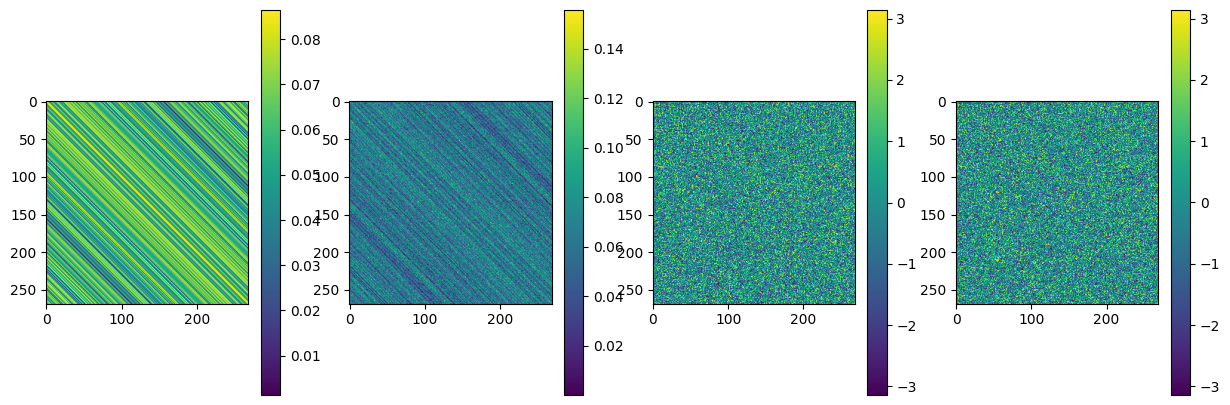

In [62]:
from copy import deepcopy

std = 2e-2

dset2 = deepcopy(dset)
dset2._coupling_matrix = (
    (np.real(dset._coupling_matrix) + std * np.random.randn(*dset._coupling_matrix.shape))
    + 1j * (np.imag(dset._coupling_matrix) + std * np.random.randn(*dset._coupling_matrix.shape))
)

fig, axs = plt.subplots(1, 4, figsize=(15,5))
pl0 = axs[0].imshow(np.abs(dset._coupling_matrix))
pl1 = axs[1].imshow(np.abs(dset2._coupling_matrix))
pl2 = axs[2].imshow(np.angle(dset._coupling_matrix))
pl3 = axs[3].imshow(np.angle(dset2._coupling_matrix))
_ = [plt.colorbar(pl, ax=axs[i]) for i, pl in enumerate([pl0, pl1, pl2, pl3])]

dset2.compute_from_transfer_matrix(phases_dim=dataset_settings['phases_dim'])
dset2.compute_fourier_transforms(**fourier_settings)

(4096, 52)


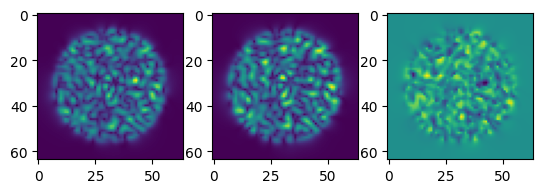

In [63]:
print(dset.reshaped_transfer_matrix.shape)

x = np.random.randn(dset.reshaped_transfer_matrix.shape[1])

y1 = dset.reshaped_transfer_matrix @ x
y2 = dset2.reshaped_transfer_matrix @ x

y1 = np.reshape(y1, [64,64])
y2 = np.reshape(y2, [64,64])

fig, axs = plt.subplots(1, 3)
axs[0].imshow(np.abs(y1))
axs[1].imshow(np.abs(y2))
axs[2].imshow(np.abs(y2) - np.abs(y1))

### Dataset checking and export

Display a random draw from the dataset as a check

Text(0.5, 1.0, 'Far field intensity')

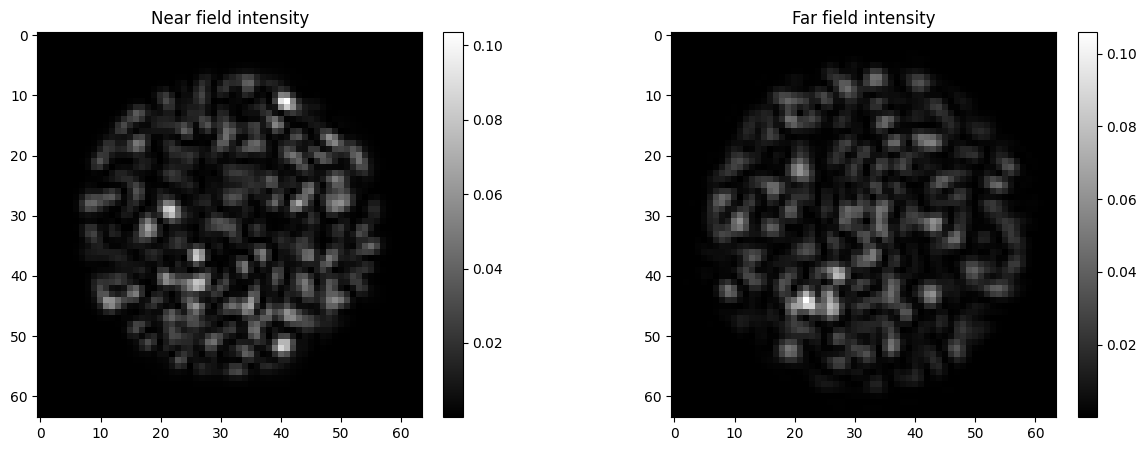

In [64]:
rand_idx = np.random.randint(0, dset._fields.shape[-1])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
nf = axs[0].imshow(dset.intensities[..., rand_idx], cmap='gray')
ff = axs[1].imshow(np.square(np.abs(dset._transf[..., rand_idx])), cmap='gray')
plt.colorbar(nf, ax=axs[0], fraction=0.046, pad=0.04)
plt.colorbar(ff, ax=axs[1], fraction=0.046, pad=0.04)
axs[0].set_title('Near field intensity')
axs[1].set_title('Far field intensity')

Export it if it looks ok

In [66]:
dset.export(**export_settings)

Dataset saved: .\synth_dset_step_lambda=1064nm_Nmodes=269_degen=True_len=5000_mirr=64_exp_noise.hdf5


In [67]:
dset2.export(**export_settings)

Dataset saved: .\synth_dset_step_lambda=1064nm_Nmodes=269_degen=True_len=5000_mirr=64_exp_noise.hdf5
